# Object detection demo
This notebook shows an example of object detection of an image.
The network that is used for inference is a variant of Tiny-Yolo, whose topology is illustrated in the following picture.
The pynq colored layers have been quantized with 1 bit for weights and 3 bit for activations, and will be executed in the HW accelerator, while the other layers are executed in python.

The image processing is performed within darknet by using python bindings.


![TinierYolo topology](Tinier-YOLO-topology.svg)

In [2]:
import sys
import os, platform
import json
import numpy as np
import cv2
import ctypes
from matplotlib import pyplot as plt
from PIL import Image
from datetime import datetime
from qnn import TinierYolo
from qnn import utils 
sys.path.append("/opt/darknet/python/")
from darknet import *
%matplotlib inline
import IPython

## 1. Instantiate a Classifier
Creating a classifier will automatically download the bitstream onto the device. All other initializations are currently performed in the Darknet framework. 

In [3]:
classifier = TinierYolo()
classifier.init_accelerator()
net = classifier.load_network(json_layer="/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-layers.json")

conv0_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-W.npy', encoding="latin1")
conv0_weights_correct = np.transpose(conv0_weights, axes=(3, 2, 1, 0))
conv8_weights = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-W.npy', encoding="latin1")
conv8_weights_correct = np.transpose(conv8_weights, axes=(3, 2, 1, 0))
conv0_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv0-bias.npy', encoding="latin1")
conv0_bias_broadcast = np.broadcast_to(conv0_bias[:,np.newaxis], (net['conv1']['input'][0],net['conv1']['input'][1]*net['conv1']['input'][1]))
conv8_bias = np.load('/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-conv8-bias.npy', encoding="latin1")
conv8_bias_broadcast = np.broadcast_to(conv8_bias[:,np.newaxis], (125,13*13))

file_name_cfg = c_char_p("/usr/local/lib/python3.6/dist-packages/qnn/params/tinier-yolo-bwn-3bit-relu-nomaxpool.cfg".encode())

net_darknet = lib.parse_network_cfg(file_name_cfg)

## 2. Launch demo

The loop will automatically pick a random image from the yoloimages folder and perform the whole classification. Use the "interrupt kernel" button on top to stop the demo

class: cow	probability: 84%
class: horse	probability: 74%
class: horse	probability: 68%


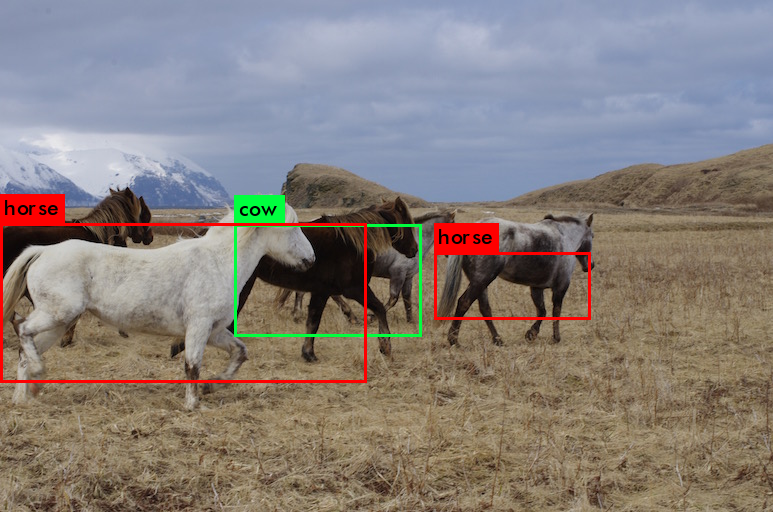

In [6]:
out_dim = net['conv7']['output'][1]
out_ch = net['conv7']['output'][0]
img_folder = './yoloimages/'
file_name_out = c_char_p("/home/xilinx/jupyter_notebooks/qnn/detection".encode())
file_name_probs = c_char_p("/home/xilinx/jupyter_notebooks/qnn/probabilities.txt".encode())
file_names_voc = c_char_p("/opt/darknet/data/voc.names".encode())
tresh = c_float(0.3)
tresh_hier = c_float(0.5)
darknet_path = c_char_p("/opt/darknet/".encode())

conv_output = classifier.get_accel_buffer(out_ch, out_dim)

while(1):
    for image_name in os.listdir(img_folder):
        img_file = os.path.join(img_folder, image_name)
        file_name = c_char_p(img_file.encode())

        img = load_image(file_name,0,0)
        img_letterbox = letterbox_image(img,416,416)
        img_copy = np.copy(np.ctypeslib.as_array(img_letterbox.data, (3,416,416)))
        img_copy = np.swapaxes(img_copy, 0,2)
        free_image(img)
        free_image(img_letterbox)

        #First convolution layer in sw
        if len(img_copy.shape)<4:
            img_copy = img_copy[np.newaxis, :, :, :]

        conv0_ouput = utils.conv_layer(img_copy,conv0_weights_correct,b=conv0_bias_broadcast,stride=2,padding=1)
        conv0_output_quant = conv0_ouput.clip(0.0,4.0)
        conv0_output_quant = utils.quantize(conv0_output_quant/4,3)

        #Offload to hardware
        conv_input = classifier.prepare_buffer(conv0_output_quant*7);
        classifier.inference(conv_input, conv_output)
        conv7_out = classifier.postprocess_buffer(conv_output)

        #Last convolution layer in sw
        conv7_out = conv7_out.reshape(out_dim,out_dim,out_ch)
        conv7_out = np.swapaxes(conv7_out, 0, 1) # exp 1
        if len(conv7_out.shape)<4:
            conv7_out = conv7_out[np.newaxis, :, :, :] 

        conv8_output = utils.conv_layer(conv7_out,conv8_weights_correct,b=conv8_bias_broadcast,stride=1)  
        conv8_out = conv8_output.ctypes.data_as(ctypes.POINTER(ctypes.c_float))

        #Draw detection boxes
        lib.forward_region_layer_pointer_nolayer(net_darknet,conv8_out)
        lib.draw_detection_python(net_darknet, file_name, tresh, tresh_hier,file_names_voc, darknet_path, file_name_out, file_name_probs);

        #Display result
        IPython.display.clear_output(1)
        file_content = open(file_name_probs.value,"r").read().splitlines()
        detections = []
        for line in file_content[0:]:
            name, probability = line.split(": ")
            detections.append((probability, name))
        for det in sorted(detections, key=lambda tup: tup[0], reverse=True):
            print("class: {}\tprobability: {}".format(det[1], det[0]))
        res = Image.open(file_name_out.value.decode() + ".png")
        display(res)

## Reset the device

In [7]:
classifier.deinit_accelerator()

In [8]:
from pynq import Xlnk

xlnk = Xlnk();
xlnk.xlnk_reset()